In [ ]:
!pip install kaggle
!pip install mediapipe #might have to restart after installing

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torchvision.models as models
import cv2
import timm
import torch.nn as nn
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch
import os
from numpy.random import RandomState
import os
import pandas as pd
import pandas as pd
import os
import cv2
import numpy as np
import torch
from PIL import Image
import mediapipe as mp
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import os
from google.colab import drive
from google.colab import drive
import os
import torch
import torch
import copy
import os
from torch.nn.utils import clip_grad_norm_


In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ameencaslam/three-body-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.60G/5.60G [01:19<00:00, 75.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ameencaslam/three-body-dataset/versions/2


In [ ]:

os.listdir(path)

['fake', 'real']

In [ ]:
#get path to real and fake folders
real=os.path.join(path,"real") #/root/.cache/kagglehub/datasets/ameencaslam/three-body-dataset/versions/2/real/15__walking_down_indoor_hall_disgust.mp4'
fake=os.path.join(path,"fake")#/root/.cache/kagglehub/datasets/ameencaslam/three-body-dataset/versions/2/fake/dfdc_train_part_0_tszsvitufh.mp4
print(real, fake)

In [ ]:


# paths
base_dir = path# contains "fake" and "real" subfolders
fake_dir = os.path.join(base_dir, "fake")
real_dir = os.path.join(base_dir, "real")

# get all video file paths (sorted to maintain order)
fake_videos = sorted([os.path.join("fake", f) for f in os.listdir(fake_dir) if f.endswith((".mp4", ".avi", ".mov"))])
real_videos = sorted([os.path.join("real", f) for f in os.listdir(real_dir) if f.endswith((".mp4", ".avi", ".mov"))])

fake_sample = fake_videos[:]
real_sample = real_videos[:]


all_videos = [(path, "fake") for path in fake_sample] + [(path, "real") for path in real_sample]

# save to CSV
df = pd.DataFrame(all_videos, columns=["video_path", "label"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv("video_dataset.csv", index=False)

print("CSV file created with", len(df), "videos")


CSV file created with 1200 videos


In [ ]:
df.head(1)

,video_path,label
0,real/id5_0004.mp4,real


In [ ]:
label_counts = df['label'].value_counts()

print("\nNumber of videos in each class:")
print(label_counts)


Number of videos in each class:
label
real    600
fake    600
Name: count, dtype: int64


In [ ]:
check=os.path.join(path,df['video_path'][0])
os.path.exists(check)

True

In [ ]:
df = df
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].replace({'real': 1, 'fake': 0})

/tmp/ipython-input-333024315.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'real': 1, 'fake': 0})


In [ ]:
df.head(1)

,video_path,label
0,real/id5_0004.mp4,1


In [ ]:


# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Assign folder names sequentially from 0 after shuffling
df['Folder_Name'] = ['video_{}'.format(i) for i in range(len(df))]

# Save updated CSV
csv_path = 'combined_df.csv'
df.to_csv(csv_path, index=False)
print("Folder_Name column added/updated sequentially after shuffling")


Folder_Name column added/updated sequentially after shuffling


In [ ]:
df.head(1)

,video_path,label,Folder_Name
0,real/12__secret_conversation.mp4,1,video_0


In [ ]:
import pandas as pd

# Load your dataset
df = df

# Shuffle the data first for randomness (optional but good practice)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute split sizes
train_size = 0.80
val_size = 0.10
test_size = 0.10

# Split the dataset
train_end = int(train_size * len(df))
val_end = train_end + int(val_size * len(df))

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Save each subset
train_df.to_csv("train_videos_mix.csv", index=False)
val_df.to_csv("val_videos_mix.csv", index=False)
test_df.to_csv("test_videos_mix.csv", index=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 960, Val: 120, Test: 120


In [ ]:
len(train_df),len(test_df), len(val_df)

(960, 120, 120)

In [ ]:
train_df.head(1), test_df.head(1), val_df.head(1)

(                              video_path  label Folder_Name
 0  fake/dfdc_train_part_0_gudedkpnie.mp4      0  video_1178,
               video_path  label Folder_Name
 1080  real/id48_0004.mp4      1   video_863,
                                             video_path  label Folder_Name
 960  fake/06_18__outside_talking_still_laughing__M3...      0   video_985)

In [ ]:


# Build timm-based ResNet50 feature extractor
def build_feature_extractor():
    model = timm.create_model(
        'xception',
        pretrained=True,
        num_classes=0,     # removes classifier
        global_pool='avg'  # keeps 2048-dim pooled features
    )
    model.eval()
    return model



device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = build_feature_extractor().to(device)

# Get the proper preprocessing config for normalization
config = resolve_data_config({}, model=feature_extractor)
timm_transform = create_transform(**config)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [4]:
config

{'input_size': (3, 299, 299),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.8975,
 'crop_mode': 'center'}

In [5]:
import torch
IMG_SIZE = 299
BATCH_SIZE = 8
EPOCHS = 20
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
NUM_CLASSES=2
EPOCHS = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/video_training_retry_7_11_25'  # main project folder
os.makedirs(DRIVE_PATH, exist_ok=True)

# Existing paths
CHECKPOINT_PATH = os.path.join(DRIVE_PATH, 'checkpoint.pth')
FINAL_MODEL_PATH = os.path.join(DRIVE_PATH, 'model.pth')

# Create separate folders for training and testing features
PROCESSED_DIR_BASE = os.path.join(DRIVE_PATH, 'processed_videos')
PROCESSED_DIR_TRAIN = os.path.join(PROCESSED_DIR_BASE, 'train')
PROCESSED_DIR_TEST = os.path.join(PROCESSED_DIR_BASE, 'test')
PROCESSED_DIR_VAL = os.path.join(PROCESSED_DIR_BASE, 'val')
# Make sure all exist
os.makedirs(PROCESSED_DIR_TRAIN, exist_ok=True)
os.makedirs(PROCESSED_DIR_TEST, exist_ok=True)

print("Folders created:")
print("Base folder:", PROCESSED_DIR_BASE)
print("Train folder:", PROCESSED_DIR_TRAIN)
print("Test folder:", PROCESSED_DIR_TEST)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folders created:
Base folder: /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos
Train folder: /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/train
Test folder: /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/test


In [ ]:

def save_features(idx, temp_features, frame_mask, save_dir=None):
    """
    Save processed video features to disk in the given directory.
    Defaults to the main processed_videos folder if none provided.
    """
    if save_dir is None:
        save_dir = PROCESSED_DIR  # fallback to main directory

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'video_{idx}.pt')

    torch.save({'features': temp_features, 'mask': frame_mask}, save_path)
    print(f"[Saved] {save_path}")


def load_features(idx, save_dir=None):
    """
    Load previously processed features if they exist in the given directory.
    Defaults to the main processed_videos folder if none provided.
    """
    if save_dir is None:
        save_dir = PROCESSED_DIR  # fallback to main directory

    path = os.path.join(save_dir, f'video_{idx}.pt')

    if os.path.exists(path):
        data = torch.load(path)
        print(f"[Loaded] {path}")
        return data['features'], data['mask']

    return None, None


In [ ]:
'''
Face detection function
Repeated conversion & resizing logic in both the if and fallback sections.
The crop logic can be slightly condensed while keeping clarity.
Frame extraction loop (frame_constructor)
Repeated cap.set, read, and fallback cropping every iteration.
Could separate “safe frame read” into a helper for cleaner logic.
Feature extraction (extract_video_features)
Creates tensors inside the loop and assigns repeatedly — could preallocate and fill more concisely.
Video preparation (prepare_all_videos)
Repeated checks for fake/real path; can merge both using dictionary lookup.
Repeated saving logic for features, mask, label.
Some console prints can be combined.
'''

'\nFace detection function\nRepeated conversion & resizing logic in both the if and fallback sections.\nThe crop logic can be slightly condensed while keeping clarity.\nFrame extraction loop (frame_constructor)\nRepeated cap.set, read, and fallback cropping every iteration.\nCould separate “safe frame read” into a helper for cleaner logic.\nFeature extraction (extract_video_features)\nCreates tensors inside the loop and assigns repeatedly — could preallocate and fill more concisely.\nVideo preparation (prepare_all_videos)\nRepeated checks for fake/real path; can merge both using dictionary lookup.\nRepeated saving logic for features, mask, label.\nSome console prints can be combined.\n'

In [ ]:
"""
Take only 20 frames (max_frames=20)
Ensure frames are evenly spaced across the video
Crop faces if found, otherwise center crop fallback
"""


# ==========================
# PARAMETERS
# ==========================
IMG_SIZE = 299
BATCH_SIZE = 8
EPOCHS = 20
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Mediapipe face detection model
# -----------------------------
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.5
)

# -----------------------------
# Face cropper
# -----------------------------
def detect_and_crop_face(frame, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Detect and crop the largest face from a frame using Mediapipe BlazeFace.
    Falls back to center crop if no face is found.
    """
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = mp_face.process(rgb)
    h, w, _ = frame.shape

    if results.detections:
        bbox = results.detections[0].location_data.relative_bounding_box
        x1, y1 = int(bbox.xmin * w), int(bbox.ymin * h)
        x2, y2 = x1 + int(bbox.width * w), y1 + int(bbox.height * h)

        # Add margin to include some context
        margin = 0.15
        dx, dy = int((x2 - x1) * margin), int((y2 - y1) * margin)
        x1, y1 = max(0, x1 - dx), max(0, y1 - dy)
        x2, y2 = min(w, x2 + dx), min(h, y2 + dy)
        cropped = frame[y1:y2, x1:x2]
    else:
        # Center crop fallback
        min_dim = min(h, w)
        start_x = (w - min_dim) // 2
        start_y = (h - min_dim) // 2
        cropped = frame[start_y:start_y + min_dim, start_x:start_x + min_dim]

    return cv2.resize(cropped, target_size)

# -----------------------------
# Uniform frame extractor + face cropping
# -----------------------------
def frame_constructor(video_path, max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    """Extract uniformly spaced face-cropped frames from video (evenly spread across full duration)."""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        print(f"Warning: No frames in {video_path}")
        return np.array([])

    # Calculate stride to sample evenly across full video
    stride = max(1, total_frames // max_frames)
    frames, count = [], 0

    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # pick frames evenly using stride
        if i % stride == 0:
            frame = detect_and_crop_face(frame, target_size=resize)
            frames.append(frame[:, :, ::-1])  # BGR → RGB
            count += 1
            if count >= max_frames:
                break

    cap.release()
    return np.array(frames)


# -----------------------------
# Frame normalization
# -----------------------------
def normalize_frame(frame):
    """Convert frame (NumPy) to normalized tensor [1,3,H,W] using timm's transform"""
    img = Image.fromarray(frame)
    tensor = timm_transform(img).unsqueeze(0)
    return tensor

# -----------------------------
# Feature extraction per video
# -----------------------------
def extract_video_features(video_path, feature_extractor, max_seq_len=MAX_SEQ_LENGTH):
    """Extract per-frame features for a single video"""
    frames = frame_constructor(video_path)
    if frames.size == 0:
        print(f"Warning: No frames extracted from {video_path}")
        return torch.zeros((max_seq_len, NUM_FEATURES)), torch.zeros(max_seq_len, dtype=torch.bool)

    temp_features = torch.zeros((max_seq_len, NUM_FEATURES), dtype=torch.float32)
    mask = torch.zeros(max_seq_len, dtype=torch.bool)
    length = min(max_seq_len, len(frames))

    for i in range(length):
        frame_tensor = normalize_frame(frames[i]).to(device)
        with torch.no_grad():
            feat = feature_extractor(frame_tensor)
        temp_features[i] = feat.squeeze(0).cpu()
        mask[i] = True

    return temp_features, mask

# -----------------------------
# Prepare all videos
# -----------------------------
def prepare_all_videos(df, save_dir):
    """
    Prepare all videos: extract features, masks, and save in folders specified by 'Folder_Name' column.
    Handles different base paths for real and fake videos.
    """
    base_path = "/kaggle/input/three-body-dataset"

    df = df.copy().reset_index(drop=True)
    df["absolute_path"] = df["video_path"].apply(lambda vp: os.path.join(base_path, vp))
    labels = torch.tensor(df["label"].values, dtype=torch.long)
    os.makedirs(save_dir, exist_ok=True)

    frame_features = torch.zeros((len(df), MAX_SEQ_LENGTH, NUM_FEATURES), dtype=torch.float32)
    frame_masks = torch.zeros((len(df), MAX_SEQ_LENGTH), dtype=torch.bool)

    for i, row in df.iterrows():
        path = row["absolute_path"]
        folder_name = str(row["Folder_Name"])
        folder_path = os.path.join(save_dir, folder_name)

        if not os.path.exists(path):
            print(f"[{folder_name}] Video file not found: {path}")
            continue

        if os.path.exists(folder_path):
            print(f"[{folder_name}] Already processed. Skipping.")
            features = torch.load(os.path.join(folder_path, "features.pt"))
            mask = torch.load(os.path.join(folder_path, "mask.pt"))
        else:
            features, mask = extract_video_features(path, feature_extractor, MAX_SEQ_LENGTH)
            os.makedirs(folder_path, exist_ok=True)
            torch.save(features, os.path.join(folder_path, "features.pt"))
            torch.save(mask, os.path.join(folder_path, "mask.pt"))
            torch.save(labels[i], os.path.join(folder_path, "label.pt"))
            print(f"[{folder_name}] {path}: {len(features)} frames processed and saved.")

        if mask.sum().item() == 0:
            print(f"[{folder_name}] No valid frames found.")

        frame_features[i] = features
        frame_masks[i] = mask
        print(f"[{folder_name}] Done.\n")

    return (frame_features, frame_masks), labels


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:

train_df=train_df[:]
test_df=test_df[:]
val_df=val_df[:]
#totla trianshould be 0-5399
#total test should be : 1400



In [ ]:
train_df.head(1)

,video_path,label,Folder_Name
0,fake/dfdc_train_part_0_gudedkpnie.mp4,0,video_1178


In [ ]:

(train_features, train_masks), train_labels = prepare_all_videos(train_df, PROCESSED_DIR_TRAIN)
(test_features, test_masks), test_labels = prepare_all_videos(test_df, PROCESSED_DIR_TEST)
(val_features, val_masks), val_labels = prepare_all_videos(val_df, PROCESSED_DIR_VAL)

[video_1178] /kaggle/input/three-body-dataset/fake/dfdc_train_part_0_gudedkpnie.mp4: 20 frames processed and saved.
[video_1178] Done.

[video_865] /kaggle/input/three-body-dataset/fake/dfdc_train_part_2_vhnnlnkeyf.mp4: 20 frames processed and saved.
[video_865] Done.

[video_101] /kaggle/input/three-body-dataset/real/id40_0003.mp4: 20 frames processed and saved.
[video_101] Done.

[video_439] /kaggle/input/three-body-dataset/real/dfdc_train_part_2_rukyxomwcx.mp4: 20 frames processed and saved.
[video_439] Done.

[video_58] /kaggle/input/three-body-dataset/real/dfdc_train_part_3_eyvsgkwrkj.mp4: 20 frames processed and saved.
[video_58] Done.

[video_1120] /kaggle/input/three-body-dataset/real/15__walking_and_outside_surprised.mp4: 20 frames processed and saved.
[video_1120] Done.

[video_323] /kaggle/input/three-body-dataset/real/id1_0004.mp4: 20 frames processed and saved.
[video_323] Done.

[video_974] /kaggle/input/three-body-dataset/fake/06_12__podium_speech_happy__0VR4Y891.mp4: 20

In [ ]:
print((train_masks.sum(dim=1) == 0).sum().item(), "samples have zero valid frames in training data")
print((test_masks.sum(dim=1) == 0).sum().item(), "samples have zero valid frames in testing data")

0 samples have zero valid frames in training data
0 samples have zero valid frames in testing data


In [ ]:

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set folder path to the video folder you want to check
VIDEO_FOLDER = '/content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/train/video_0'  # example

# 4. Load features, mask, and label
features_path = os.path.join(VIDEO_FOLDER, "features.pt")
mask_path = os.path.join(VIDEO_FOLDER, "mask.pt")
label_path = os.path.join(VIDEO_FOLDER, "label.pt")

features = torch.load(features_path)
print("Features shape:", len(features))
mask = torch.load(mask_path)
print("Mask shape:", mask.shape)

label = torch.load(label_path)
print("Label:", label)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Features shape: 20
Mask shape: torch.Size([20])
Label: tensor(1)


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler
from collections import Counter, defaultdict
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader

# ====================================
# Dataset class for processed videos
# ====================================
class ProcessedVideoDataset(Dataset):
    def __init__(self, processed_dir):
        self.processed_dir = processed_dir
        self.folders = sorted([
            f for f in os.listdir(processed_dir)
            if os.path.isdir(os.path.join(processed_dir, f))
        ])
        print(f"Found {len(self.folders)} video folders in {processed_dir}")

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]
        folder_path = os.path.join(self.processed_dir, folder)

        features = torch.load(os.path.join(folder_path, "features.pt"), map_location="cpu")
        mask = torch.load(os.path.join(folder_path, "mask.pt"), map_location="cpu")
        label = torch.load(os.path.join(folder_path, "label.pt"), map_location="cpu")

        return features, mask, label


# ====================================
# Dataloader function
# ====================================
def get_dataloader(processed_dir, batch_size=8, num_workers=0, shuffle=True):
    dataset = ProcessedVideoDataset(processed_dir)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,num_workers=num_workers,pin_memory=False)
    return dataloader


# ====================================
# Define paths
# ====================================
PROCESSED_DIR_TRAIN = "/content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/train"
PROCESSED_DIR_VAL   = "/content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/val"
PROCESSED_DIR_TEST  = "/content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/test"

# ====================================
# Create loaders
# ====================================
train_loader = get_dataloader(PROCESSED_DIR_TRAIN, batch_size=8)
val_loader   = get_dataloader(PROCESSED_DIR_VAL, batch_size=8, shuffle=False)
test_loader  = get_dataloader(PROCESSED_DIR_TEST, batch_size=8, shuffle=False)

# ====================================
# Quick check
# ====================================
for features, masks, labels in train_loader:
    print("Batch shapes:", features.shape, masks.shape, labels.shape)
    break



Found 960 video folders in /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/train
Found 120 video folders in /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/val
Found 120 video folders in /content/drive/MyDrive/video_training_retry_7_11_25/processed_videos/test
Batch shapes: torch.Size([8, 20, 2048]) torch.Size([8, 20]) torch.Size([8])


In [ ]:
#lstm sequence model
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMSequenceModel(nn.Module):
    def __init__(self, num_features, max_seq_length, num_classes):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=num_features, hidden_size=16, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=16, hidden_size=8, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, num_classes)
    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, num_features)
        lengths = mask.sum(dim=1) if mask is not None else torch.full((x.size(0),), x.size(1), dtype=torch.long).to(x.device)
        lengths = torch.clamp(lengths, min=1)  # Prevent zero lengths
        # Pack padded sequence for the LSTM
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (h1, _) = self.lstm1(packed)
        packed_output, (h2, _) = self.lstm2(packed_output)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1))

        # Get the last valid output in each sequence according to actual length
        idx = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, output.shape[2])
        last_outputs = output.gather(1, idx).squeeze(1)
        x = self.dropout(last_outputs)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #print(x.shape) 16,2
        return x  # logits


'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass LSTMAttentionModel(nn.Module):\n    def __init__(self, num_features, num_classes, hidden_dim=128):\n        super().__init__()\n\n        # ----- Projection MLP -----\n        # Compress or expand feature space before feeding into LSTM\n        self.projection = nn.Sequential(\n            nn.Linear(num_features, 512),\n            nn.BatchNorm1d(512),\n            nn.ReLU(),\n            nn.Dropout(0.3),\n            nn.Linear(512, 256),\n            nn.BatchNorm1d(256),\n            nn.ReLU(),\n            nn.Dropout(0.4),\n        )\n\n        # ----- Bidirectional LSTM -----\n        self.lstm = nn.LSTM(\n            input_size=256,        # from projection MLP\n            hidden_size=hidden_dim,\n            num_layers=1,\n            batch_first=True,\n            bidirectional=True\n        )\n\n        # ----- Attention Mechanism -----\n        self.attention = nn.Sequential(\n            nn.Linea

In [10]:
model = LSTMSequenceModel(num_features=NUM_FEATURES, max_seq_length=MAX_SEQ_LENGTH, num_classes=NUM_CLASSES)

In [ ]:


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    """Run one full epoch of training and validation."""
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for features, masks, labels in train_loader:
        features, masks, labels = [x.to(device) for x in (features, masks, labels)]
        optimizer.zero_grad()
        logits = model(features, masks)
        loss = criterion(logits, labels)
        loss.backward()

        # Gradient Clipping — prevents exploding gradients in LSTMs
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / total
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for features, masks, labels in val_loader:
            features, masks, labels = [x.to(device) for x in (features, masks, labels)]
            logits= model(features, masks)
            preds = logits.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    return avg_train_loss, train_acc, val_acc


def train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    checkpoint_path="checkpoint.pth",
    final_model_path="best_model.pth",
    scheduler=None,
    num_epochs=15,
    autosave_every=2,
    resume=False,
    new_data_phase=False
):
    """
    Trains model with checkpointing and resume support (no early stopping).
    """

    start_epoch = 0
    best_val_acc = 0.0
    best_model_state = copy.deepcopy(model.state_dict())

    # Resume or continue from checkpoint
    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if checkpoint.get('scheduler_state_dict') and scheduler:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        if new_data_phase:
            start_epoch = 0
            best_val_acc = 0.0
            print("[Continue Training on New Data] Loaded model weights & optimizer state. Resetting counters.")
        else:
            start_epoch = checkpoint.get('epoch', 0)
            best_val_acc = checkpoint.get('best_val_acc', 0.0)
            print(f"[Resume Training] Loaded checkpoint from epoch {start_epoch}, Val Acc: {best_val_acc:.4f}")

        best_model_state = copy.deepcopy(model.state_dict())

    print(f"Starting training from epoch {start_epoch+1}/{num_epochs}...")

    for epoch in range(start_epoch, num_epochs):
        avg_train_loss, train_acc, val_acc = train_and_validate(
            model, train_loader, val_loader, criterion, optimizer, device
        )

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # Step scheduler if present
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:
                scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

        # Save checkpoint periodically
        if (epoch + 1) % autosave_every == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': avg_train_loss,
                'best_val_acc': best_val_acc,
            }, checkpoint_path)
            print(f"[Checkpoint Saved] at epoch {epoch+1}")

    # Load best model
    model.load_state_dict(best_model_state)
    torch.save(best_model_state, final_model_path)
    print(f"[Training Complete] Best model saved to {final_model_path} | Best Val Acc: {best_val_acc:.4f}")


In [ ]:
model = model.to(DEVICE)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
EPOCHS = 30
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "/content/drive/MyDrive/video_training_retry_7_11_25/checkpoint.pth"
FINAL_MODEL_PATH = "/content/drive/MyDrive/video_training_retry_7_11_25/model.pth"

AUTOSAVE_EVERY = 1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#    optimizer, mode='max', factor=0.5, patience=3
#)
scheduler = CosineAnnealingLR(optimizer, T_max=25)
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    checkpoint_path=CHECKPOINT_PATH,
    final_model_path=FINAL_MODEL_PATH,
    num_epochs=EPOCHS,
    scheduler=scheduler,
    autosave_every=AUTOSAVE_EVERY,
    resume=True
)



Starting training from epoch 1/30...
Epoch 1/30 | Train Loss: 0.4515 | Train Acc: 0.8125 | Val Acc: 0.6917
[Checkpoint Saved] at epoch 1
Epoch 2/30 | Train Loss: 0.4066 | Train Acc: 0.8594 | Val Acc: 0.7917
[Checkpoint Saved] at epoch 2
Epoch 3/30 | Train Loss: 0.3936 | Train Acc: 0.8552 | Val Acc: 0.7750
[Checkpoint Saved] at epoch 3
Epoch 4/30 | Train Loss: 0.3515 | Train Acc: 0.8729 | Val Acc: 0.7500
[Checkpoint Saved] at epoch 4
Epoch 5/30 | Train Loss: 0.3246 | Train Acc: 0.8844 | Val Acc: 0.7250
[Checkpoint Saved] at epoch 5
Epoch 6/30 | Train Loss: 0.3429 | Train Acc: 0.8708 | Val Acc: 0.7583
[Checkpoint Saved] at epoch 6
Epoch 7/30 | Train Loss: 0.2915 | Train Acc: 0.9042 | Val Acc: 0.7833
[Checkpoint Saved] at epoch 7
Epoch 8/30 | Train Loss: 0.2609 | Train Acc: 0.9115 | Val Acc: 0.7583
[Checkpoint Saved] at epoch 8
Epoch 9/30 | Train Loss: 0.2401 | Train Acc: 0.9250 | Val Acc: 0.7667
[Checkpoint Saved] at epoch 9
Epoch 10/30 | Train Loss: 0.2390 | Train Acc: 0.9219 | Val Acc:

In [ ]:
model = LSTMSequenceModel(num_features=NUM_FEATURES, max_seq_length=MAX_SEQ_LENGTH, num_classes=NUM_CLASSES)
#model=BiLSTMSequenceModel(num_features=NUM_FEATURES, max_seq_length=MAX_SEQ_LENGTH, num_classes=NUM_CLASSES)
#model =LSTMAttentionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

model_path = r'/content/drive/MyDrive/video_training_retry_7_11_25/model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

print(f"Model loaded successfully from: {model_path}")

model.eval()  # sets model to evaluation mode (no dropout, no gradient updates)



Test Accuracy: 94.69%


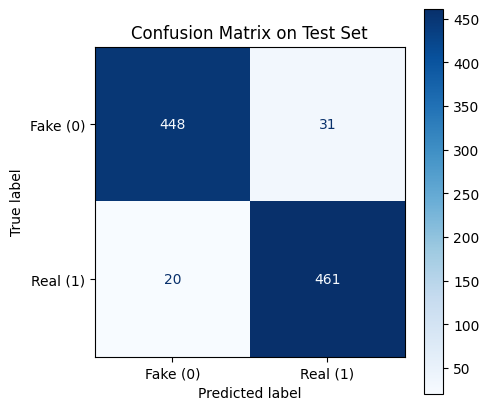


Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.94      0.95       479
        Real       0.94      0.96      0.95       481

    accuracy                           0.95       960
   macro avg       0.95      0.95      0.95       960
weighted avg       0.95      0.95      0.95       960



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

model.eval()
test_correct = 0
test_total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in train_loader:
        features, masks, labels = [x.to(device) for x in batch]
        logits= model(features, masks)

        preds = logits.argmax(1)

        # Track overall accuracy
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        # Save for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc*100:.2f}%")


cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix on Test Set")
plt.show()


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Fake", "Real"]))


In [43]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import mediapipe as mp
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# ============================
# CONFIG
# ============================
IMG_SIZE = 299
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================
# MODEL DEFINITIONS
# ============================

# ============================
# FEATURE EXTRACTOR (Xception)
# ============================

feature_extractor = build_feature_extractor().to(device)
config = resolve_data_config({}, model=feature_extractor)
timm_transform = create_transform(**config)

# ============================
# FACE DETECTION + CROPPING
# ============================
mp_face = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

def detect_and_crop_face(frame, target_size=(IMG_SIZE, IMG_SIZE)):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = mp_face.process(rgb)
    h, w, _ = frame.shape
    if results.detections:
        bbox = results.detections[0].location_data.relative_bounding_box
        x1, y1 = int(bbox.xmin * w), int(bbox.ymin * h)
        x2, y2 = x1 + int(bbox.width * w), y1 + int(bbox.height * h)
        margin = 0.15
        dx, dy = int((x2 - x1) * margin), int((y2 - y1) * margin)
        x1, y1 = max(0, x1 - dx), max(0, y1 - dy)
        x2, y2 = min(w, x2 + dx), min(h, y2 + dy)
        cropped = frame[y1:y2, x1:x2]
    else:
        min_dim = min(h, w)
        start_x, start_y = (w - min_dim)//2, (h - min_dim)//2
        cropped = frame[start_y:start_y+min_dim, start_x:start_x+min_dim]
    return cv2.resize(cropped, target_size)

# ============================
# FRAME EXTRACTION + FEATURES
# ============================
def frame_constructor(video_path, max_frames=MAX_SEQ_LENGTH):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total == 0:
        cap.release()
        return np.array([])
    stride = max(1, total // max_frames)
    frames, count = [], 0
    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i % stride == 0:
            frame = detect_and_crop_face(frame)
            frames.append(frame[:, :, ::-1])
            count += 1
            if count >= max_frames:
                break
    cap.release()
    return np.array(frames)

def normalize_frame(frame):
    img = Image.fromarray(frame)
    return timm_transform(img).unsqueeze(0)

def extract_video_features(video_path, feature_extractor, max_seq_len=MAX_SEQ_LENGTH):
    frames = frame_constructor(video_path)
    if frames.size == 0:
        return torch.zeros((max_seq_len, NUM_FEATURES)), torch.zeros(max_seq_len, dtype=torch.bool)
    features = torch.zeros((max_seq_len, NUM_FEATURES))
    mask = torch.zeros(max_seq_len, dtype=torch.bool)
    for i in range(min(max_seq_len, len(frames))):
        frame_tensor = normalize_frame(frames[i]).to(device)
        with torch.no_grad():
            feat = feature_extractor(frame_tensor)
        features[i] = feat.squeeze(0).cpu()
        mask[i] = True
    return features, mask

# ============================
# INFERENCE
# ============================
def predict_single_video(video_path, model, feature_extractor, device="cuda"):
    model.eval()
    with torch.no_grad():
        features, mask = extract_video_features(video_path, feature_extractor)
        features = features.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)
        logits = model(features, mask)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
        label = "Real" if pred.item() == 1 else "Fake"
    print(f"\nVideo: {video_path}")
    print(f"Prediction: {label}")
    print(f"Confidence: {conf.item():.4f}")
    print(f"Probabilities: {probs.squeeze().cpu().tolist()}")

# ============================
# MAIN EXECUTION
# ============================
if __name__ == "__main__":
    # Load model
    model =model = LSTMSequenceModel(num_features=NUM_FEATURES, max_seq_length=MAX_SEQ_LENGTH, num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load("/content/drive/MyDrive/video_training_retry_7_11_25/model.pth", map_location=device))
    model.to(device)

    # Path to a single test video
    test_video = "/root/.cache/kagglehub/datasets/ameencaslam/three-body-dataset/versions/2/real/04__secret_conversation.mp4"

    # Run inference
    predict_single_video(test_video, model, feature_extractor, device)



Video: /root/.cache/kagglehub/datasets/ameencaslam/three-body-dataset/versions/2/real/04__secret_conversation.mp4
Prediction: Real
Confidence: 0.9891
Probabilities: [0.010920467786490917, 0.9890795350074768]
